In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import pandas as pd
import numpy as np
import re
import sys
import os

In [22]:
# Función para gráficar histogramas de variables numéricas (hecho con ayuda de deepseek r1)
def plot_numeric_analysis(df, numeric_cols, figsize=(15, 10)):
    """Gráfica histogramas de variables numéricas, adaptando los ejes a la data."""
    if not numeric_cols:
        print("No hay columnas numéricas para graficar.")
        return

    n_cols = min(3, len(numeric_cols))
    n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

    if len(numeric_cols) <= 2:
        figsize = (8, 5)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    fig.suptitle('Análisis de Variables Numéricas', fontsize=16)

    # Aplanar los ejes para simplificar la iteración
    axes = np.array(axes).flatten() if isinstance(axes, np.ndarray) else np.array([axes])

    for idx, col in enumerate(numeric_cols):
        # Se extrae la data de la columna ignorando valores nulos
        data = df[col].dropna()
        # Se calcula un margen del 5% del rango para que el gráfico no esté muy pegado a los bordes
        if not data.empty and np.isfinite(data).all():
            margin = 0.05 * (data.max() - data.min()) if data.max() != data.min() else 0.5
            x_min = data.min() - margin
            x_max = data.max() + margin
            
            # Graficamos el histograma usando bins automáticos para mejor adaptación
            sns.histplot(data=df, x=col, ax=axes[idx], bins='auto')
            axes[idx].set_title(f'Distribución de {col}')
            
            # Solo establecer límites si son finitos
            if np.isfinite(x_min) and np.isfinite(x_max):
                axes[idx].set_xlim(x_min, x_max)
        else:
            # Si no hay datos válidos o contiene infinitos/NaN
            axes[idx].text(0.5, 0.5, 'No hay datos válidos para graficar',
                          horizontalalignment='center', verticalalignment='center',
                          transform=axes[idx].transAxes)
            axes[idx].set_title(f'Distribución de {col}')

    # Ocultar subplots no utilizados
    for idx in range(len(numeric_cols), len(axes)):
        axes[idx].set_visible(False)

    # Ajustamos el layout dejando espacio para el título general
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Función para detectar outlayers con el método IQR, extremos y no extremos
def iqr_method(column):
    """Detecta outliers usando el método IQR."""
    q1 = column.quantile(0.25)
    q3 = column.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    extreme_lower_bound = q1 - 3 * iqr
    extreme_upper_bound = q3 + 3 * iqr
    return pd.Series([column>upper_bound, column<lower_bound, column>extreme_upper_bound, column<extreme_lower_bound], 
                     index=['outliers_upper', 'outliers_lower', 'extreme_upper', 'extreme_lower'])

# Función para realizar un análisis exploratorio de una tabla (mejorado con ayuda de claude 3.7 sonnet)
def analisis_exploratorio(name, df):
    """Realiza un análisis exploratorio de una tabla."""
    total_chars = 125
    print("="*total_chars)
    string = f"Análisis de la tabla {name}"
    print('|' + string.center(total_chars-2) + '|')
    print("="*total_chars)
    print(f"Dimensiones: {df.shape}")
    
    # Expresión regular para identificar columnas ID
    id_pattern = re.compile(
        r'^id_.*|.*_id$|^id$',  # Empieza con id_, termina con _id, o es exactamente id
        flags=re.IGNORECASE
    )
    id_cols = [col for col in df.columns if id_pattern.fullmatch(col)]
    
    # Separar columnas numéricas y no numéricas
    numeric_cols = [col for col in df.select_dtypes(include=['int64', 'float64']).columns if col not in id_cols]
    non_numeric_cols = list(df.select_dtypes(exclude=['int64', 'float64']).columns)
    
    # Normalizar strings y manejar IDs
    for col in non_numeric_cols:
        if pd.api.types.is_string_dtype(df[col]):
            df[col] = df[col].apply(lambda x: x.lower().strip() if pd.notna(x) else x)
    
    # Agregar IDs a no numéricas para estadísticas especiales
    non_numeric_cols += id_cols

    non_numeric_stats = []
    if non_numeric_cols:
        for col in non_numeric_cols:
            stats = {
                'Columna': col,
                'Valores Únicos': df[col].nunique(),
                'Media': '-',
                'Desviación Estándar': '-',
                'Mínimo': df[col].min() if col in id_cols else '-',
                'Mediana': '-',
                'Máximo': df[col].max() if col in id_cols else '-'
            }
            non_numeric_stats.append(stats)
    
    numeric_stats = []
    cols_to_remove = []
    if numeric_cols:
        for col in numeric_cols:
            if df[col].nunique() == 2 and set(df[col].dropna().unique()).issubset({0, 1}):
                df[col] = df[col].astype('boolean')
                cols_to_remove.append(col)
            else:
                numeric_stats.append({
                    'Columna': col,
                    'Valores Únicos': df[col].nunique(),
                    'Media': df[col].mean(),
                    'Desviación Estándar': df[col].std(),
                    'Mínimo': df[col].min(),
                    'Mediana': df[col].median(),
                    'Máximo': df[col].max()
                })
        # Remover columnas convertidas a boolean
        numeric_cols = [col for col in numeric_cols if col not in cols_to_remove]
    
    # Crear un único DataFrame con todas las estadísticas
    all_stats = []
    
    for col in df.columns:
        is_numeric = col in numeric_cols
        
        stats = {
            'Columna': col,
            'Valores Únicos': df[col].nunique(),
            'Media': df[col].mean() if is_numeric else '-',
            'Desviación Estándar': df[col].std() if is_numeric else '-',
            'Mínimo': df[col].min() if is_numeric or col in id_cols else '-',
            'Mediana': df[col].median() if is_numeric else '-',
            'Máximo': df[col].max() if is_numeric or col in id_cols else '-',
            'Tipos de datos': df[col].apply(type).unique() if len(df[col].apply(type).unique()) == 1 else '\n'.join(str(t) for t in df[col].apply(type).unique()),
            'NaN/Null': df[col].isnull().sum(),
            'Duplicados únicos': len(df[(df.duplicated(subset=[col], keep='first'))&(df[col].notnull())]),
            'Duplicados totales': len(df[(df.duplicated(subset=[col], keep=False))&(df[col].notnull())])
        }
        
        # Agregar información de outliers solo para columnas numéricas
        if is_numeric:
            iqr_stats = iqr_method(df[col])
            stats.update({
                'Outlayers (IQR extreme_lower)': iqr_stats['extreme_lower'].sum(),
                'Outlayers (IQR lower)': iqr_stats['outliers_lower'].sum(),
                'Outlayers (IQR upper)': iqr_stats['outliers_upper'].sum(),
                'Outlayers (IQR extreme_upper)': iqr_stats['extreme_upper'].sum()
            })
        else:
            stats.update({
                'Outlayers (IQR extreme_lower)': '-',
                'Outlayers (IQR lower)': '-',
                'Outlayers (IQR upper)': '-',
                'Outlayers (IQR extreme_upper)': '-'
            })
            
        all_stats.append(stats)
    
    # Crear un único DataFrame con todas las estadísticas
    all_stats_df = pd.DataFrame(all_stats).set_index('Columna')
    inconsistencias_stats_df = all_stats_df.T
    
    print('\nEstadísticas descriptivas y problemas de calidad:')
    print(inconsistencias_stats_df.to_markdown(index=True))
    
    if numeric_cols:
        # Filtrar columnas numéricas que contienen valores infinitos o NaN
        valid_numeric_cols = []
        for col in numeric_cols:
            if df[col].dropna().empty or not np.isfinite(df[col].dropna()).all():
                print(f"Advertencia: La columna '{col}' contiene valores no finitos y no será graficada.")
            else:
                valid_numeric_cols.append(col)
        
        if valid_numeric_cols:
            plot_numeric_analysis(df, valid_numeric_cols)
        else:
            print("No hay columnas numéricas válidas para graficar.")
    return

|                                                 Análisis de la tabla Apple                                                |
Dimensiones: (11144, 11)

Estadísticas descriptivas y problemas de calidad:
|                               | Date            | Open               | High               | Low                | Close              | Volume            | Open_SP500         | High_SP500         | Low_SP500          | Close_SP500        | Volume_SP500       |
|:------------------------------|:----------------|:-------------------|:-------------------|:-------------------|:-------------------|:------------------|:-------------------|:-------------------|:-------------------|:-------------------|:-------------------|
| Valores Únicos                | 11144           | 8134               | 10355              | 10166              | 10524              | 10580             | 10769              | 10707              | 10753              | 10457              | 10564              |
| Media        

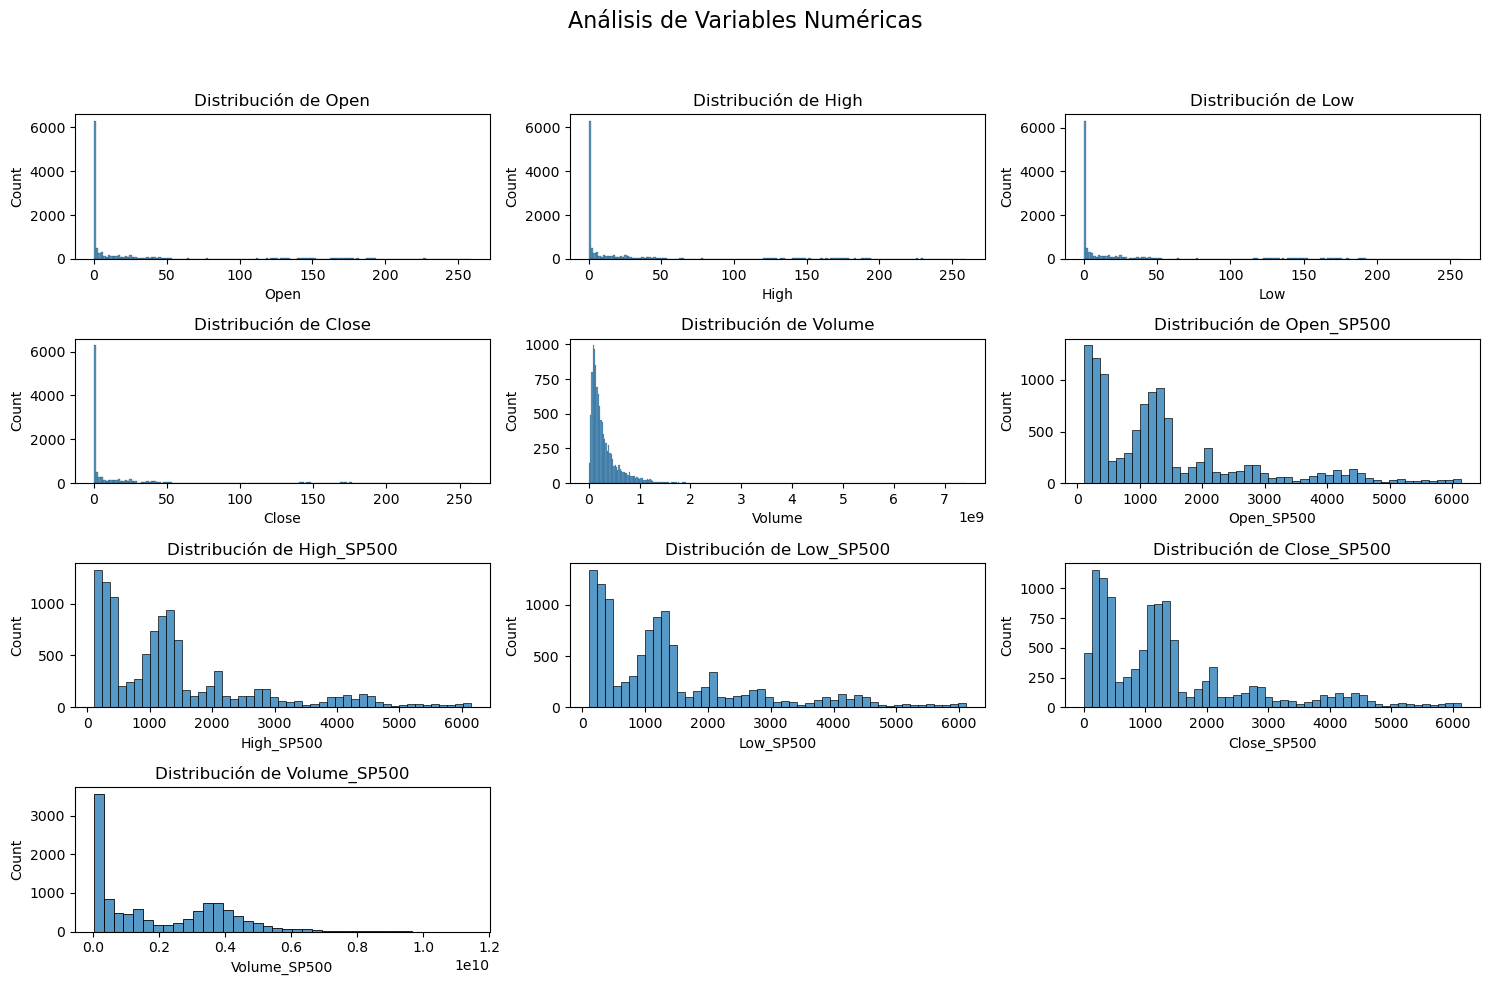

In [23]:
apple_data = pd.read_csv('../data/raw/AAPL_with_SP500.csv')
analisis_exploratorio('Apple', apple_data)

Las unicas irregularidades que se encuentran son los valores nulos que se generaron al calcular el SMA, RSI, MACD y las bandas de Bollinger. Por lo que se va a proceder a eliminar los registros con valores nulos

In [24]:
print(f"Número de registros antes de eliminar los valores nulos: {len(apple_data)}")
apple_data = apple_data.dropna()
print(f"Número de registros después de eliminar los valores nulos: {len(apple_data)}")

Número de registros antes de eliminar los valores nulos: 11144
Número de registros después de eliminar los valores nulos: 11144


In [25]:
apple_data.to_csv('../data/processed/AAPL_with_SP500_clean.csv', index=False)

|                                                Análisis de la tabla Amazon                                                |
Dimensiones: (6992, 11)

Estadísticas descriptivas y problemas de calidad:
|                               | Date            | Open               | High               | Low                | Close             | Volume             | Open_SP500         | High_SP500         | Low_SP500          | Close_SP500        | Volume_SP500       |
|:------------------------------|:----------------|:-------------------|:-------------------|:-------------------|:------------------|:-------------------|:-------------------|:-------------------|:-------------------|:-------------------|:-------------------|
| Valores Únicos                | 6992            | 6348               | 6209               | 6213               | 6251              | 6797               | 6847               | 6833               | 6840               | 6853               | 6794               |
| Media         

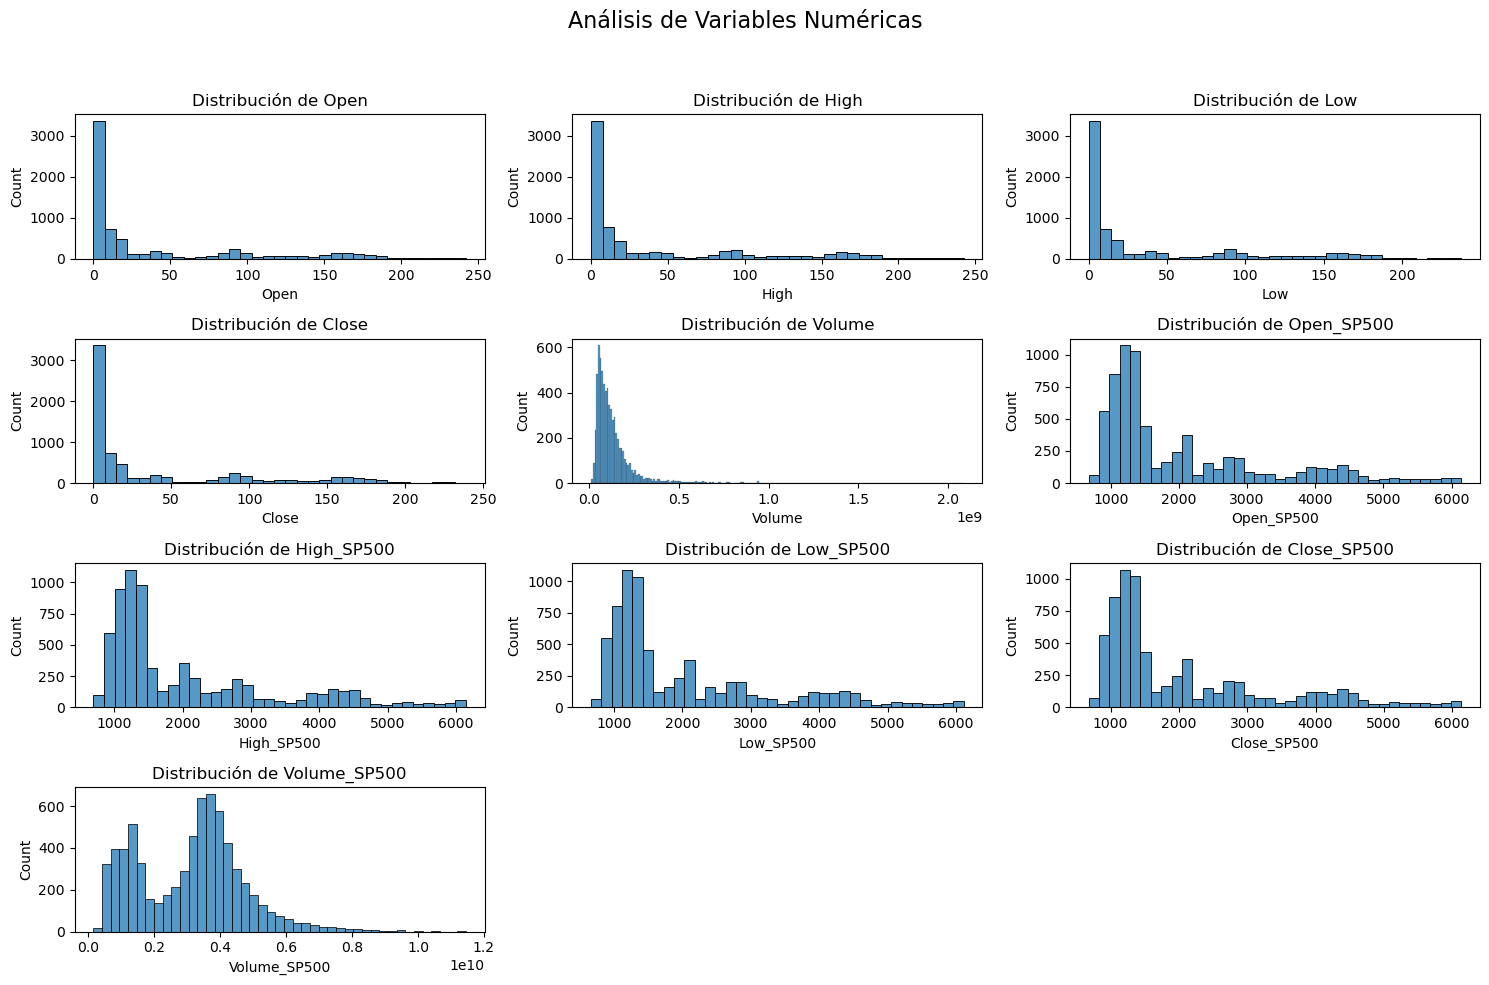

In [26]:
amazon_data = pd.read_csv('../data/raw/AMZN_with_SP500.csv')
analisis_exploratorio('Amazon', amazon_data)

Igualmente que con Apple eliminaremos los registros con valores nulos.

In [27]:
print(f"Número de registros antes de eliminar los valores nulos: {len(amazon_data)}")
amazon_data = amazon_data.dropna()
print(f"Número de registros después de eliminar los valores nulos: {len(amazon_data)}")
amazon_data.to_csv('../data/processed/AMZN_with_SP500_clean.csv', index=False)

Número de registros antes de eliminar los valores nulos: 6992
Número de registros después de eliminar los valores nulos: 6992


|                                               Análisis de la tabla Microsoft                                              |
Dimensiones: (9818, 11)



Estadísticas descriptivas y problemas de calidad:
|                               | Date            | Open               | High               | Low                | Close              | Volume             | Open_SP500         | High_SP500         | Low_SP500          | Close_SP500        | Volume_SP500       |
|:------------------------------|:----------------|:-------------------|:-------------------|:-------------------|:-------------------|:-------------------|:-------------------|:-------------------|:-------------------|:-------------------|:-------------------|
| Valores Únicos                | 9818            | 7712               | 9520               | 9513               | 9634               | 9626               | 9549               | 9493               | 9558               | 9549               | 9426               |
| Media                         | -               | 57.97856158579296  | 58.539441672393195 | 57.37161837438732  | 57.9667959482543   | 56247172.67264209  | 1572.5

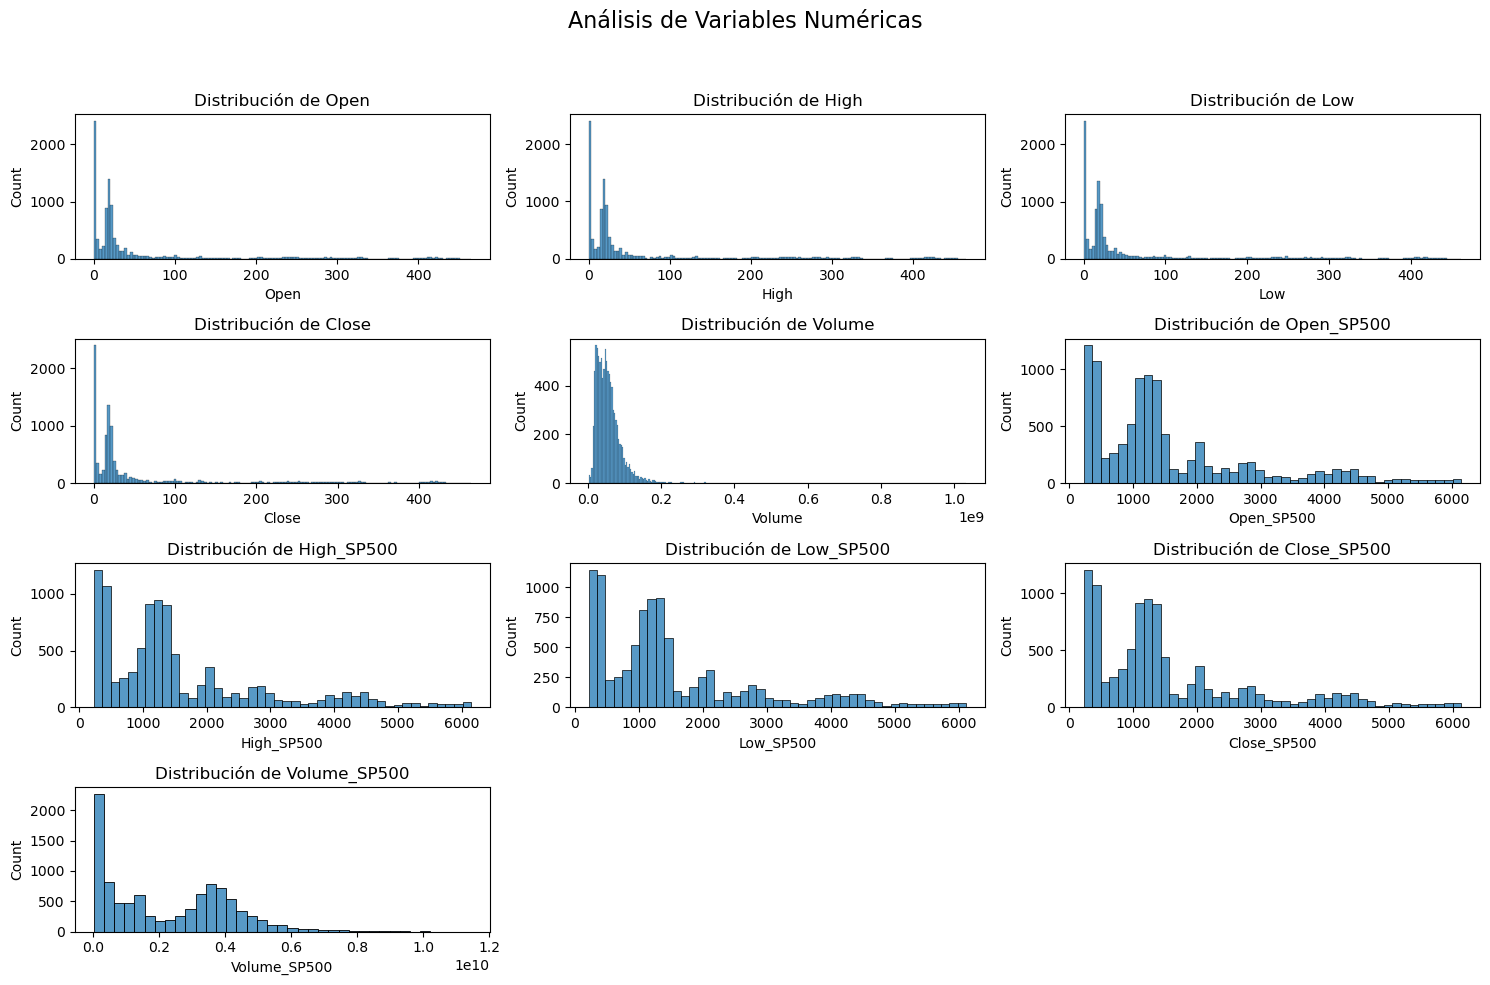

In [28]:
microsoft_data = pd.read_csv('../data/raw/MSFT_with_SP500.csv')
analisis_exploratorio('Microsoft', microsoft_data)

Repetimos

In [29]:
print(f"Número de registros antes de eliminar los valores nulos: {len(microsoft_data)}")
microsoft_data = microsoft_data.dropna()
print(f"Número de registros después de eliminar los valores nulos: {len(microsoft_data)}")
microsoft_data.to_csv('../data/processed/MSFT_with_SP500_clean.csv', index=False)

Número de registros antes de eliminar los valores nulos: 9818
Número de registros después de eliminar los valores nulos: 9818


|                                                Análisis de la tabla NVIDIA                                                |
Dimensiones: (6567, 11)

Estadísticas descriptivas y problemas de calidad:
|                               | Date            | Open               | High               | Low                | Close              | Volume            | Open_SP500         | High_SP500         | Low_SP500         | Close_SP500        | Volume_SP500       |
|:------------------------------|:----------------|:-------------------|:-------------------|:-------------------|:-------------------|:------------------|:-------------------|:-------------------|:------------------|:-------------------|:-------------------|
| Valores Únicos                | 6567            | 5525               | 6540               | 6531               | 6550               | 6483              | 6446               | 6434               | 6439              | 6449               | 6385               |
| Media            

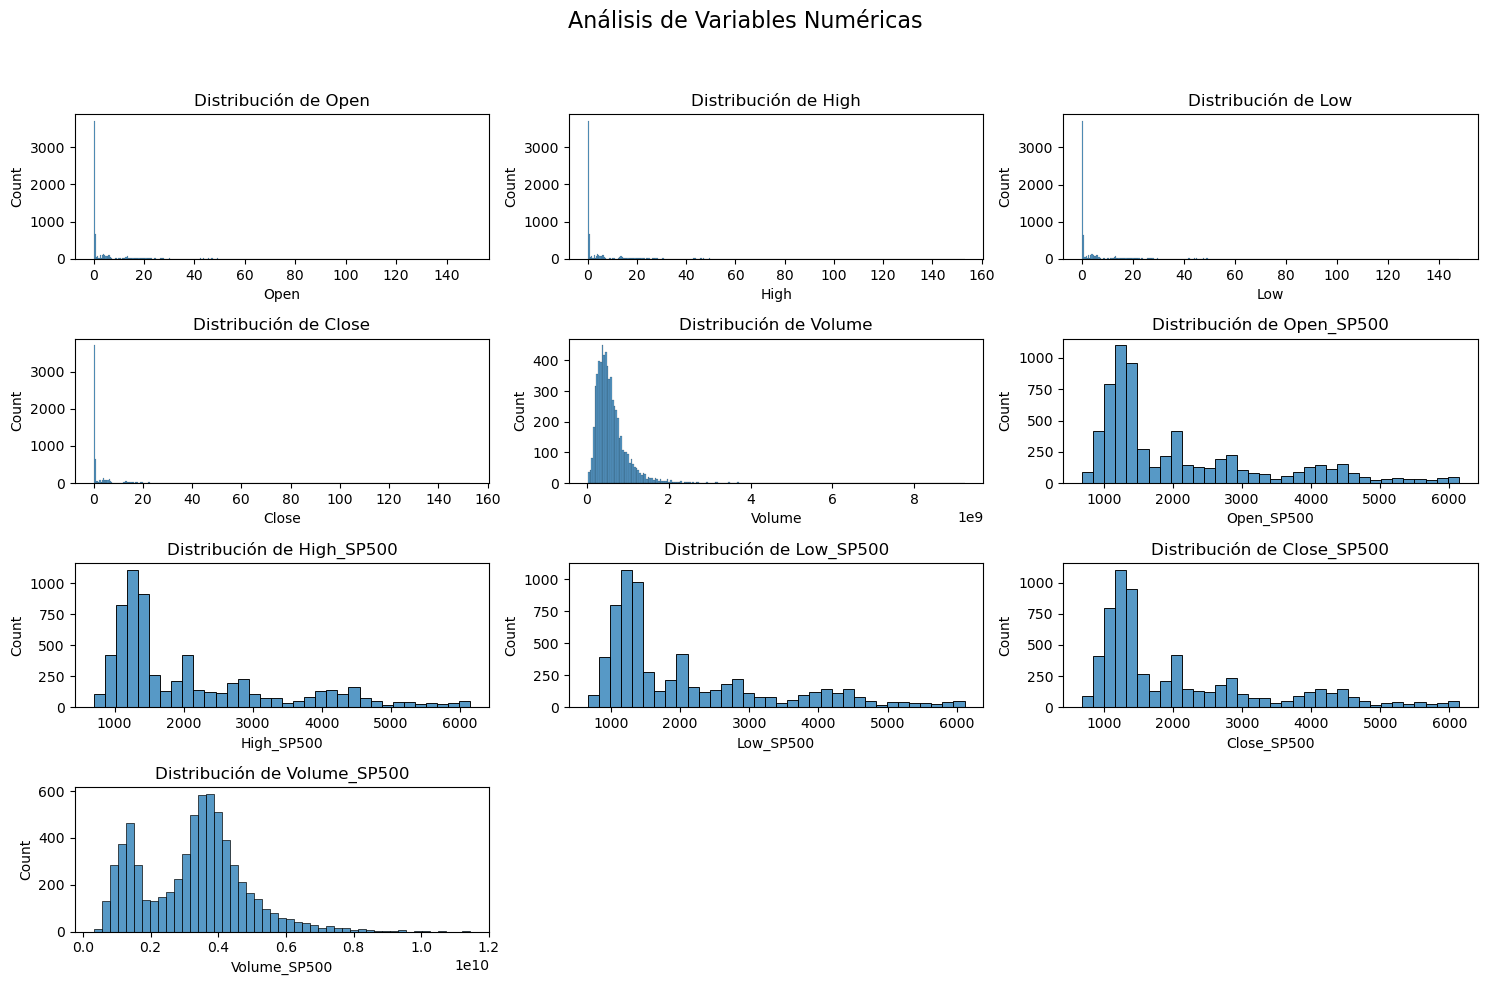

In [30]:
nvidia_data = pd.read_csv('../data/raw/NVDA_with_SP500.csv')
analisis_exploratorio('NVIDIA', nvidia_data)

Repetimos

In [31]:
print(f"Número de registros antes de eliminar los valores nulos: {len(nvidia_data)}")
nvidia_data = nvidia_data.dropna()
print(f"Número de registros después de eliminar los valores nulos: {len(nvidia_data)}")
nvidia_data.to_csv('../data/processed/NVDA_with_SP500_clean.csv', index=False)

Número de registros antes de eliminar los valores nulos: 6567
Número de registros después de eliminar los valores nulos: 6567


|                                                Análisis de la tabla Google                                                |
Dimensiones: (5166, 11)

Estadísticas descriptivas y problemas de calidad:
|                               | Date            | Open               | High               | Low                | Close              | Volume             | Open_SP500         | High_SP500         | Low_SP500          | Close_SP500        | Volume_SP500       |
|:------------------------------|:----------------|:-------------------|:-------------------|:-------------------|:-------------------|:-------------------|:-------------------|:-------------------|:-------------------|:-------------------|:-------------------|
| Valores Únicos                | 5166            | 5069               | 5166               | 5166               | 5166               | 5041               | 5112               | 5098               | 5107               | 5104               | 5092               |
| Media      

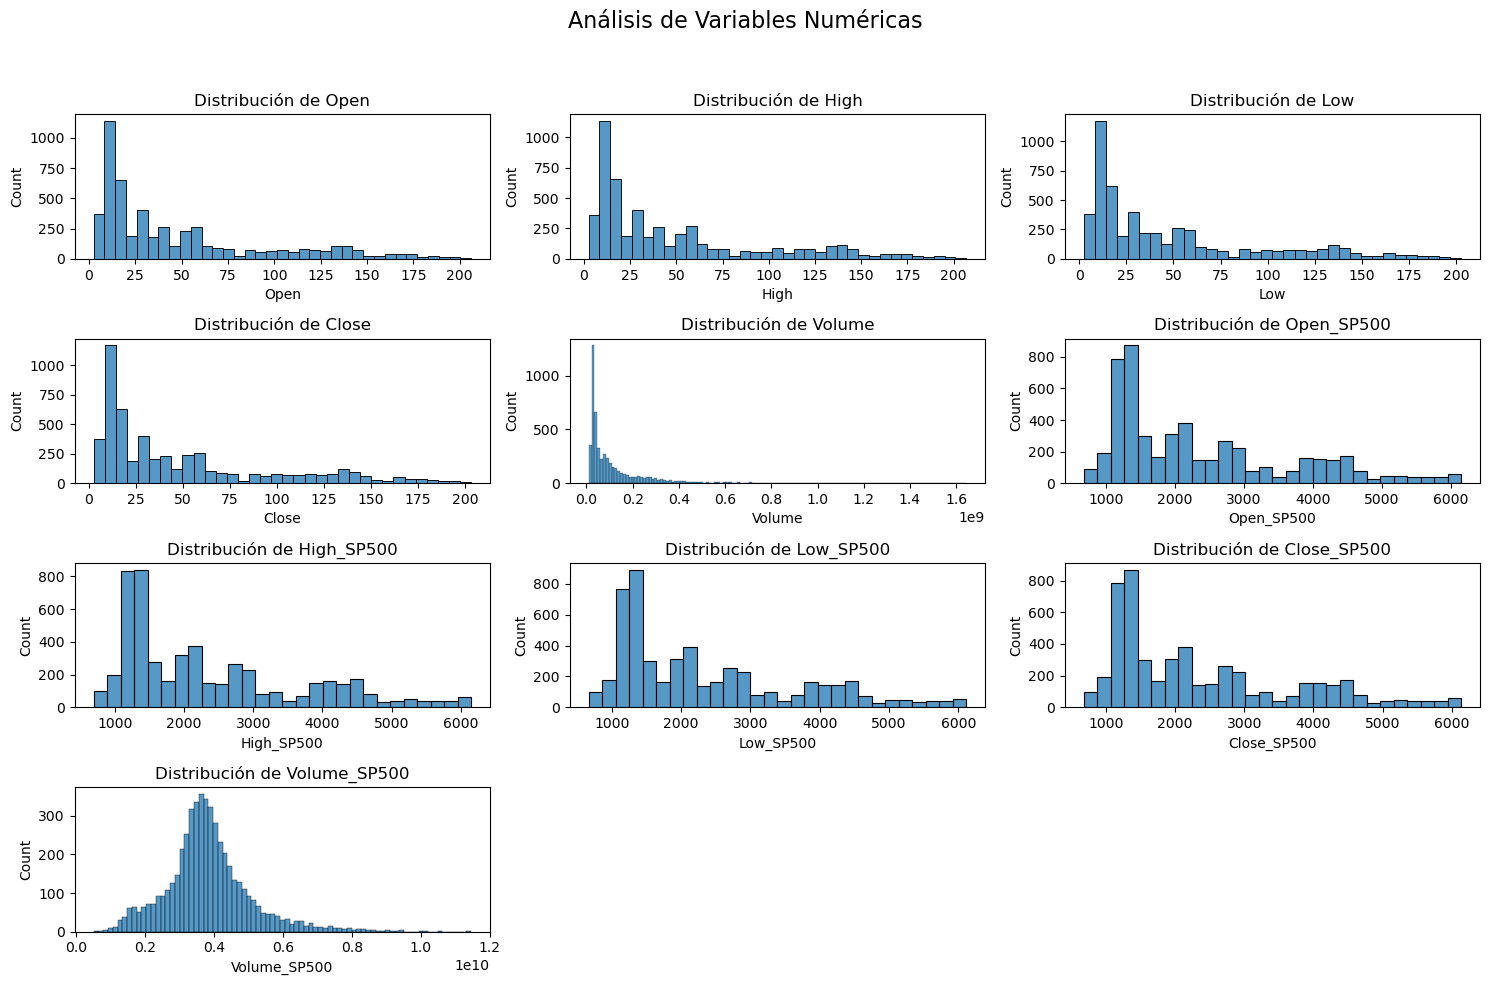

In [32]:
google_data = pd.read_csv('../data/raw/GOOGL_with_SP500.csv')
analisis_exploratorio('Google', google_data)

Repetimos

In [33]:
print(f"Número de registros antes de eliminar los valores nulos: {len(google_data)}") 
google_data = google_data.dropna()
print(f"Número de registros después de eliminar los valores nulos: {len(google_data)}")
google_data.to_csv('../data/processed/GOOGL_with_SP500_clean.csv', index=False)

Número de registros antes de eliminar los valores nulos: 5166
Número de registros después de eliminar los valores nulos: 5166
